<a href="https://colab.research.google.com/github/JamesBarciz/DS-Unit-2-Applied-Modeling/blob/master/module2/James_Barciz_assignment_applied_modeling_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 2*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - _**[A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)**_
  - [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
  - _**[Boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw) (2.5 minute video)**_

In [1]:
import pandas as pd
from google.colab import files
uploaded = files.upload()

Saving musicfeatures.zip to musicfeatures.zip


In [0]:
# Run this if the file is not .zip format
# And upload other CSV
uploaded1 = files.upload()

Saving data_2genre.csv to data_2genre.csv


In [2]:
!unzip musicfeatures.zip

Archive:  musicfeatures.zip
  inflating: data.csv                
  inflating: data_2genre.csv         


In [0]:
df = pd.read_csv('data.csv')
df2 = pd.read_csv('data_2genre.csv')

In [4]:
df = pd.concat([df, df2])
df.shape

(1200, 30)

In [0]:
genres = []

for i in df['filename']:
  genres.append(i[:-9])

In [0]:
df.insert(1, 'genre', genres)

In [7]:
df.head()

,filename,genre,tempo,beats,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00081.au,blues,103.359375,50,0.380260,0.248262,2116.942959,1956.611056,4196.107960,0.127272,-26.929785,107.334008,-46.809993,40.932634,-21.463776,24.816275,-18.945571,15.253459,-15.050104,12.262823,-15.234050,14.336612,-13.821769,7.562789,-6.181372,0.330165,-6.829571,0.965922,-7.570825,2.918987,blues
1,blues.00022.au,blues,95.703125,44,0.306451,0.113475,1156.070496,1497.668176,2170.053545,0.058613,-233.860772,136.170239,3.289490,48.931193,8.699106,13.954752,5.359449,0.381334,-13.490265,16.871769,5.145258,-2.250578,3.959198,5.322555,0.812028,-1.107202,-4.556555,-2.436490,3.316913,-0.608485,blues
2,blues.00031.au,blues,151.999081,75,0.253487,0.151571,1331.073970,1973.643437,2900.174130,0.042967,-221.802549,110.843070,18.620984,30.922996,3.291330,22.587447,-20.418303,12.120995,-26.347956,-4.356270,-26.406674,-13.037723,-12.652228,-1.821905,-7.260097,-6.660252,-14.682694,-11.719264,-11.025216,-13.387260,blues
3,blues.00012.au,blues,184.570312,91,0.269320,0.119072,1361.045467,1567.804596,2739.625101,0.069124,-207.208080,132.799175,-15.438986,60.986727,0.725807,12.437828,1.183836,-1.540779,-17.888154,8.358496,-2.452068,-0.613248,0.384877,2.605128,-5.188924,-9.527455,-9.244394,-2.848274,-1.418707,-5.932607,blues
4,blues.00056.au,blues,161.499023,74,0.391059,0.137728,1811.076084,2052.332563,3927.809582,0.075480,-145.434568,102.829023,-12.517677,56.993472,2.271347,26.591402,-4.274803,17.338809,-7.985593,15.235427,-6.934599,7.457218,-10.470444,-2.360483,-6.783623,2.671134,-4.760879,-0.949005,0.024832,-2.005315,blues


In [8]:
df.describe()

,tempo,beats,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,119.650771,56.882500,0.370632,0.129331,2203.833135,2246.295208,4571.216473,0.103968,-152.721641,100.395629,-8.013423,33.542958,-0.325353,12.691159,-4.346226,8.534651,-6.040324,6.880125,-5.694288,3.696146,-4.212006,1.364958,-3.308531,0.962490,-3.322924,0.514315,-1.958679,-0.975615
std,28.595204,14.484769,0.084014,0.070874,767.091516,580.235661,1721.201024,0.041925,111.544452,33.575997,22.263053,17.019680,11.948240,12.053005,9.951567,10.657989,8.406946,7.923118,6.578539,6.660127,6.032812,4.979126,4.870773,4.520644,4.674349,3.836801,3.770014,3.781028
min,54.978391,18.000000,0.171782,0.005276,569.930721,897.994319,749.062137,0.021701,-552.064063,-1.527148,-89.901142,-18.768461,-38.903451,-28.424546,-32.933588,-24.947537,-31.653059,-12.051190,-28.052265,-15.805227,-27.542309,-12.598773,-17.545474,-15.693589,-17.227765,-11.975698,-18.504188,-19.935203
25%,99.384014,47.000000,0.304514,0.079168,1548.496850,1815.497242,3172.968313,0.070809,-217.159272,74.875960,-24.244142,20.293901,-8.715006,3.362419,-12.147550,0.316628,-12.263692,0.974232,-10.095268,-0.967632,-8.376523,-2.048828,-6.514669,-2.005988,-6.667356,-2.003979,-4.405887,-3.272533
50%,117.453835,55.000000,0.376657,0.122036,2192.798091,2223.270960,4603.684662,0.099478,-121.409818,98.738478,-9.681929,32.630813,0.726648,11.652651,-4.765624,7.012029,-6.154043,5.875009,-5.505038,2.979597,-3.621954,1.351666,-3.007097,0.966397,-3.201921,0.665095,-1.902843,-0.985806
75%,135.999178,65.000000,0.432291,0.182267,2753.175473,2664.676118,5679.811488,0.132843,-69.786929,123.917582,7.919558,46.055974,8.456293,22.723798,3.654184,17.430779,0.623991,13.394796,-0.868188,8.714135,0.388630,4.696107,0.068461,3.994902,-0.089599,3.021267,0.620840,1.381480
max,234.907670,117.000000,0.663573,0.398012,4434.439444,3509.578677,8676.405868,0.274829,42.034587,193.096518,56.666090,80.691273,31.461661,45.173178,21.835769,49.018887,19.129207,27.216746,17.421038,23.037571,13.054333,18.161663,12.357588,13.468803,11.489994,15.379257,14.686910,15.368966


In this dataset I will predict the musical genre of a song (or piece) using various features.

In [0]:
# My target column is the genre of each recorded song - this is only available
# In the 0th column df['filename']; however, it is jumbled up with extraneous
# Characters that possibly denote the track number as well as the type of file
# Therefore, I engineered another column called 'genre' that matched df['filename']
# Minus the 9 characters at the end.  Because the track numbers seem to be 
# Different I thought about keeping that as another column but it probably wouldn't
# Be important when it came to predicting the genre.

target = 'genre'

***Regression or Classification?***

As the number of possible answers are finite (see code below), this would be a **classification** problem rather than regression.

In [10]:
print('Number of Unique Values:', df['label'].nunique())
print('List of Possible Genres:', df['label'].unique()) 

Number of Unique Values: 12
List of Possible Genres: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock' 1 2]


In [11]:
# A possible issue with this classification problem is that the number of
# Observations for each genre is not equal to one another...

df['label'].value_counts()

jazz         100
blues        100
reggae       100
hiphop       100
pop          100
disco        100
country      100
metal        100
rock         100
classical    100
2            100
1            100
Name: label, dtype: int64

In [12]:
df['genre'].value_counts(normalize=True)

pop          0.166667
classical    0.166667
jazz         0.083333
blues        0.083333
reggae       0.083333
hiphop       0.083333
disco        0.083333
country      0.083333
metal        0.083333
rock         0.083333
Name: genre, dtype: float64

We can see that both **Classical** and **Pop** have 100 more observations than every other genre in the list.

- Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?

In [13]:
# Before I take the time to choose which features would work well in predicting
# The target I wanted to research the column names to see what I may or may not
# Already understand as to what has been measured and recorded.

df.columns

Index(['filename', 'genre', 'tempo', 'beats', 'chroma_stft', 'rmse',
       'spectral_centroid', 'spectral_bandwidth', 'rolloff',
       'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5',
       'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12',
       'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19',
       'mfcc20', 'label'],
      dtype='object')

Each feature except for 'genre' was extracted using the LibROSA package for Python which is used for music and audio analyses. 

In [0]:
import numpy as np
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.80, test_size=0.20, 
                              stratify=df['genre'], random_state=42)

In [0]:
train, val = train_test_split(train, train_size=0.8, test_size=0.2,
                              stratify=train['genre'], random_state=42)

In [16]:
for df in train, val, test:
  print(df.shape)

(768, 31)
(192, 31)
(240, 31)


In [0]:
#target = 'genre'
X_train = train.drop(columns=[target, 'filename', 'label'])
y_train = train[target]
X_val = val.drop(columns=[target, 'filename', 'label'])
y_val = val[target]
X_test = test

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    StandardScaler(),
    SGDClassifier(max_iter=1000)
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('sgdclassifier',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                               max_iter=1000, n_iter_no_change=5, n_jobs=None,
                               penalty='l2', power_t=0.5, random_state=None,
                               shuffle=True, tol=0.001, validation_fraction=0.1,
                               verbose=0, warm_start=False))],
         verbose=False)

In [24]:
from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.5677083333333334


In [27]:
from sklearn.ensemble import RandomForestClassifier
pipeline = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(random_state=42)
)

pipeline.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=10, n_jobs=None,
                                        oob_score=False, random_state=42,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [28]:
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.578125


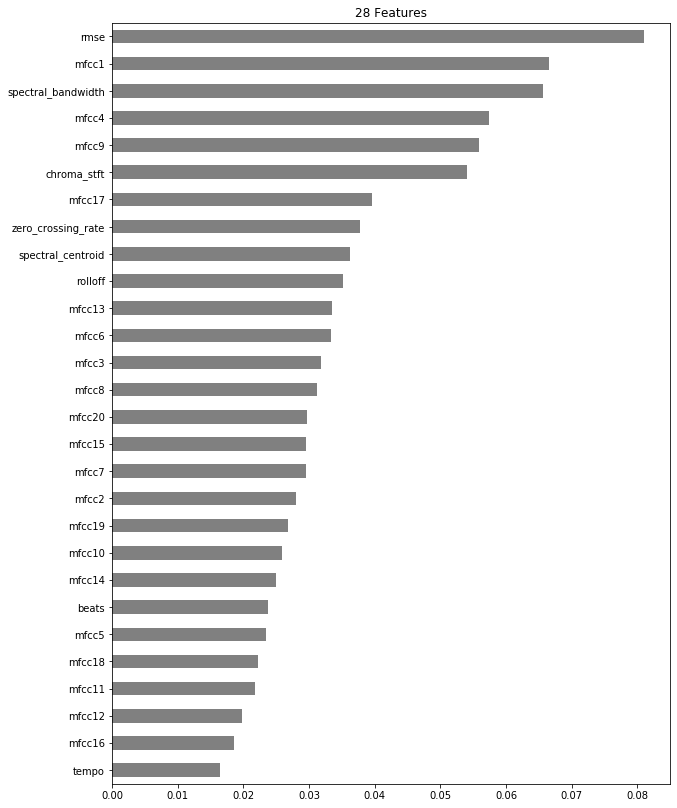

In [30]:
import matplotlib.pyplot as plt

rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

%matplotlib inline

n = len(X_train.columns)
plt.figure(figsize=(10, n/2))
plt.title(f'{n} Features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [35]:
# Fit with all the columns
pipeline = make_pipeline(
    StandardScaler(), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train, y_train)
score_with = pipeline.score(X_val, y_val)
print(f'Validation Accuracy with {column}: {score_with}')

for column in X_train.columns:

  # Fit without column
  pipeline = make_pipeline(
      StandardScaler(), 
      RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
  )
  pipeline.fit(X_train.drop(columns=column), y_train)
  score_without = pipeline.score(X_val.drop(columns=column), y_val)

  # Compare the error with & without column
  print(f'Drop-Column Importance for {column}: {score_with - score_without}')

Validation Accuracy with rmse: 0.6197916666666666
Drop-Column Importance for tempo: 0.015625
Drop-Column Importance for beats: -0.015625
Drop-Column Importance for chroma_stft: 0.02083333333333326
Drop-Column Importance for rmse: 0.01041666666666663
Drop-Column Importance for spectral_centroid: 0.01041666666666663
Drop-Column Importance for spectral_bandwidth: 0.0
Drop-Column Importance for rolloff: 0.0
Drop-Column Importance for zero_crossing_rate: 0.01041666666666663
Drop-Column Importance for mfcc1: 0.015625
Drop-Column Importance for mfcc2: 0.0
Drop-Column Importance for mfcc3: -0.00520833333333337
Drop-Column Importance for mfcc4: 0.03125
Drop-Column Importance for mfcc5: -0.01041666666666674
Drop-Column Importance for mfcc6: 0.01041666666666663
Drop-Column Importance for mfcc7: 0.0
Drop-Column Importance for mfcc8: -0.01041666666666674
Drop-Column Importance for mfcc9: 0.0
Drop-Column Importance for mfcc10: 0.005208333333333259
Drop-Column Importance for mfcc11: -0.01041666666666

In [37]:
!pip install eli5

     |████████████████████████████████| 112kB 3.0MB/s 


In [39]:
pipeline = make_pipeline(
    StandardScaler()
)

X_train_transformed = pipeline.fit_transform(X_train)
X_val_transformed = pipeline.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [40]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)
permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                                                     

In [41]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=X_val.columns.tolist()
)

Weight,Feature
0.0604 ± 0.0333,mfcc4
0.0552 ± 0.0313,chroma_stft
0.0333 ± 0.0193,zero_crossing_rate
0.0187 ± 0.0106,mfcc20
0.0177 ± 0.0083,tempo
0.0177 ± 0.0141,mfcc15
0.0167 ± 0.0078,mfcc13
0.0167 ± 0.0138,mfcc2
0.0104 ± 0.0066,mfcc3
0.0104 ± 0.0373,mfcc17


In [45]:
X_train.shape

(768, 28)

In [46]:
minimum_importance = 0
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train1 = X_train[features]
print(f'Shape after removing features:', X_train1.shape)

Shape after removing features: (768, 20)


In [47]:
X_val1 = X_val[features]

pipeline = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train1, y_train)
print('Validation Accuracy:', pipeline.score(X_val1, y_val))

Validation Accuracy: 0.6458333333333334


In [56]:
from xgboost import XGBClassifier

pipeline = make_pipeline(
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train1, y_train)
print('Validation Accuracy:', pipeline.score(X_val1, y_val))

Validation Accuracy: 0.6354166666666666


In trying Gradient Boosting the accuracy went down compared to my last model - I could choose more options for my pipeline maybe?